<H1>Step 1: Recueillir les données (Data Collection)</H1>

In [3]:
import pandas as pd
#charger le fichier Excel 
file_path= '/home/lamsiyehkhawla/Downloads/sales.xlsx'
sales_df=pd.read_excel(file_path)
print("Colonnes du fichier :", sales_df.columns.tolist())



Colonnes du fichier : ['OrderNumber', 'OrderDate', 'Ship Date', 'Customer Name Index', 'Channel', 'Currency Code', 'Warehouse Code', 'Delivery Region Index', 'Product Description Index', 'Order Quantity', 'Unit Selling Price', 'Unit Cost']


In [116]:
import pandas as pd
#charger le fichier Excel 
file_path= '/home/lamsiyehkhawla/Downloads/sales.xlsx'
sales_df=pd.read_excel(file_path)

# Netooyage des colonnes
sales_df.columns = sales_df.columns.str.strip()
#renommer les colonnes à utiliser 
sales_df= sales_df.rename(columns={
    'OrderDate': 'Date',
    'Order Quantity': 'Order_Quantity',
    'Unit Selling Price': 'Unit_Selling_Price',
    'Unit Cost': 'Unit_cost',
    'Customer Name Index': 'Customer',
    'Product Description Index': 'Product',
    'Delivery Region Index': 'Region',
    'Channel' : 'Channel',
    'Customer Name Index' : 'Customer'
})
# Calculer les champs nécessaires 
sales_df['Sales']=sales_df['Order_Quantity'] * sales_df['Unit_Selling_Price']
sales_df['Cost'] = sales_df['Order_Quantity'] * sales_df['Unit_cost']
sales_df['Profit'] = sales_df['Sales'] - sales_df['Cost']
print(sales_df.head())

    OrderNumber       Date  Ship Date  Customer      Channel Currency Code  \
0   SO - 000225 2017-01-01 2017-01-13        28    Wholesale           NZD   
1  SO - 0003378 2017-01-01 2017-01-06         7  Distributor           NZD   
2  SO - 0003901 2017-01-01 2017-01-05        12    Wholesale           NZD   
3  SO - 0005126 2017-01-01 2017-01-17         5    Wholesale           USD   
4  SO - 0005614 2017-01-01 2017-01-07        27       Export           NZD   

  Warehouse Code  Region  Product  Order_Quantity  Unit_Selling_Price  \
0         AXW291      71       11               6              2499.1   
1         AXW291      54        7              11              2351.7   
2         AXW291      58       13               5              1728.6   
3         AXW291      29        7               6               978.2   
4         AXW291      31        6               7              2338.3   

   Unit_cost    Sales       Cost     Profit  
0   1824.343  14994.6  10946.058   4048.542  


<H1> Step 2: Nettoyage et transformation (ETL)</H1> 


In [38]:
#Supprimer les doublons
sales_df=sales_df.drop_duplicates()

print("Valeurs manquantes par colonne :")
print(sales_df.isna().sum())
sales_df = sales_df.dropna(subset=['Date','Sales','Profit','Cost','Order_Quantity'])

sales_df['Date'] = pd.to_datetime(sales_df['Date'])

print(sales_df.dtypes)

Valeurs manquantes par colonne :
OrderNumber           0
Date                  0
Ship Date             0
Customer              0
Channel               0
Currency Code         0
Warehouse Code        0
Region                0
Product               0
Order_Quantity        0
Unit_Selling_Price    0
Unit_cost             0
Sales                 0
Cost                  0
Profit                0
dtype: int64
OrderNumber                   object
Date                  datetime64[ns]
Ship Date             datetime64[ns]
Customer                       int64
Channel                       object
Currency Code                 object
Warehouse Code                object
Region                         int64
Product                        int64
Order_Quantity                 int64
Unit_Selling_Price           float64
Unit_cost                    float64
Sales                        float64
Cost                         float64
Profit                       float64
dtype: object


<H1>Step 3: Créer un DataFrame des dates</H1>

In [39]:
#Extraire les dates min et max 
min_date = sales_df['Date'].min()
max_date = sales_df['Date'].max()

#Créer la table des dates 
#Genrer les ates entre la date min et max d'une maniere quotidienne 
date_range = pd.date_range(start=min_date, end=max_date,freq='D')
#DataFrame contiendra une seule colonne 'Date' qui contient toutes les dates générées dans date_range.
date_df = pd.DataFrame({'Date': date_range})
#Cela extrait l'année de chaque date dans la colonne 'Date' et la place dans une nouvelle colonne 'Year'.
date_df['Year'] = date_df['Date'].dt.year
#ela extrait le mois (sous forme de nombre de 1 à 12) et l'ajoute dans la colonne 'Month'
date_df['Month'] = date_df['Date'].dt.month
#Cela extrait le nom complet du mois (par exemple, "janvier", "février") et l'ajoute dans la colonne 
date_df['Month_Name'] = date_df['Date'].dt.strftime('%B')
#Cela détermine le trimestre de l'année (1, 2, 3 ou 4) et l'ajoute dans la colonne 'Quarter'.
date_df['Quarter'] = date_df['Date'].dt.quarter
#ela extrait le nom du jour de la semaine (par exemple, "lundi", "mardi") et l'ajoute dans la colonne 
date_df['Weekday'] = date_df['Date'].dt.day_name()

print(date_df.head())


        Date  Year  Month Month_Name  Quarter    Weekday
0 2017-01-01  2017      1    January        1     Sunday
1 2017-01-02  2017      1    January        1     Monday
2 2017-01-03  2017      1    January        1    Tuesday
3 2017-01-04  2017      1    January        1  Wednesday
4 2017-01-05  2017      1    January        1   Thursday


In [111]:
# Ajouter les noms de ville depuis la feuille 'regions'
regions_df = pd.read_excel(file_path, sheet_name='Regions')
regions_df.columns = regions_df.columns.str.strip()

# Fusion sur les index de région
sales_df = pd.merge(
    sales_df,
    regions_df[['Index', 'City']],
    left_on='Region',
    right_on='Index',
    how='left'
)
sales_df.drop(columns=['Index'], inplace=True)

In [118]:
customers_df = pd.read_excel(file_path, sheet_name='Customers')
customers_df.columns = customers_df.columns.str.strip()

# Cast to string if needed
sales_df['Customer'] = sales_df['Customer'].astype(str)
customers_df['Customer Index'] = customers_df['Customer Index'].astype(str)

# Merge to get Customer Names
sales_df = pd.merge(
    sales_df,
    customers_df[['Customer Index', 'Customer Names']],
    left_on='Customer',
    right_on='Customer Index',
    how='left'
)

# Clean up
sales_df.drop(columns=['Customer Index'], inplace=True)
sales_df = sales_df.rename(columns={'Customer Names': 'Customer_Name'})
print(sales_df)

       OrderNumber       Date  Ship Date Customer      Channel Currency Code  \
0      SO - 000225 2017-01-01 2017-01-13       28    Wholesale           NZD   
1     SO - 0003378 2017-01-01 2017-01-06        7  Distributor           NZD   
2     SO - 0003901 2017-01-01 2017-01-05       12    Wholesale           NZD   
3     SO - 0005126 2017-01-01 2017-01-17        5    Wholesale           USD   
4     SO - 0005614 2017-01-01 2017-01-07       27       Export           NZD   
...            ...        ...        ...      ...          ...           ...   
7986  SO - 0005237 2019-12-12 2019-12-16       41    Wholesale           NZD   
7987  SO - 0005477 2019-12-12 2019-12-27       28  Distributor           AUD   
7988  SO - 0006936 2019-12-12 2019-12-27       30    Wholesale           NZD   
7989  SO - 0007126 2019-12-12 2019-12-25        6  Distributor           USD   
7990  SO - 0007668 2019-12-12 2019-12-25        4    Wholesale           NZD   

     Warehouse Code  Region  Product  O

<H1>Step 4: Créer les mesures et indicateurs</H1>

In [85]:
sales_df_copy = sales_df.copy()

#Ajouter colonne annee et mois
sales_df_copy['Year'] = sales_df_copy['Date'].dt.year
sales_df_copy['Month'] = sales_df_copy['Date'].dt.month
sales_df_copy['Month_Name'] = sales_df_copy['Date'].dt.strftime('%B')


print(sales_df_copy[['Date','Year','Month','Month_Name','City','Customer_Name']].head())

        Date  Year  Month Month_Name              City Customer_Name  \
0 2017-01-01  2017      1    January  Queenstown-Lakes    Dharma Ltd   
1 2017-01-01  2017      1    January      Christchurch       New Ltd   
2 2017-01-01  2017      1    January          Hamilton      Medline    
3 2017-01-01  2017      1    January            Timaru  Procter Corp   
4 2017-01-01  2017      1    January         Waitakere    Wuxi Group   

  Customer_Name  
0    Dharma Ltd  
1       New Ltd  
2      Medline   
3  Procter Corp  
4    Wuxi Group  


<H2>Total Sales</H2>



In [46]:
total_sales = sales_df_copy['Sales'].sum()
print(f"Total sales : {total_sales:.2f} MAD")

Total sales : 154573140.60 MAD


<h2>Total Sales PY (Previous Year)</h2>

In [47]:
# contiendra un nouveau DataFrame avec deux colonnes Year et Sales
#Le résultat est un DataFrame propre où chaque ligne contient une année et le total des ventes pour cette année.
sales_by_year = sales_df_copy.groupby('Year')['Sales'].sum().reset_index()

print("Ventes par année")
print(sales_by_year)

if len(sales_by_year) >= 2:
    current_year_sales = sales_by_year.iloc[-1]['Sales']
    prev_year_sales = sales_by_year.iloc[-2]['Sales']
else:
    current_year_sales = total_sales
    prev_year_sales = 0

Ventes par année
   Year       Sales
0  2017  52580534.7
1  2018  53463661.7
2  2019  48528944.2


<h2>Total Sales/PY Var</h2>

In [48]:
sales_diff = current_year_sales - prev_year_sales
print(f"Difference ventes (année en cours - précédente) : {sales_diff:.2f} MAD")

Difference ventes (année en cours - précédente) : -4934717.50 MAD


<h2>Total Sales/PY Var %</h2>

In [11]:
if prev_year_sales != 0:
    sales_var_pct = (sales_diff / prev_year_sales) * 100
else:
    sales_var_pct = 0

print(f"VAriation en % des ventes YOY : {sales_var_pct : .2f}%")

VAriation en % des ventes YOY : -9.23%


<h2>Total Order Quantity</h2>

In [12]:
total_orders =sales_df_copy['Order_Quantity'].sum()
print(f"Quantité totale commandée : {total_orders}")

Quantité totale commandée : 67579


<h2>Total Profit</h2>

In [13]:
total_profit=sales_df_copy['Profit'].sum()
print(f"Profit total :{total_profit:.2f}MAD")

Profit total :57789142.91MAD


<h2>Total Profit PY</h2>

In [14]:
profit_by_year = sales_df_copy.groupby('Year')['Profit'].sum().reset_index()

print("Profit par année :")
print(profit_by_year)
if len(profit_by_year) >=2:
    current_profit = profit_by_year.iloc[-1]['Profit']
    prev_profit = profit_by_year.iloc[-2]['Profit']
else:
    current_profit = total_profit
    prev_profit = 0

Profit par année :
   Year        Profit
0  2017  1.967777e+07
1  2018  1.978919e+07
2  2019  1.832218e+07


<h2>Total Profit/PY Var </h2>

In [15]:
profit_diff = current_profit - prev_profit
print(f" Différence profit : {profit_diff:.2f} MAD")

 Différence profit : -1467008.35 MAD


<h2>Total Profit/PY Var % </h2>

In [16]:
if prev_profit != 0:
    profit_var_pct = (profit_diff / prev_profit) * 100
else:
    profit_var_pct = 0
print(f" Variation % du profit YOY : {profit_var_pct:.2f}%")

 Variation % du profit YOY : -7.41%


<h2>Profit Margin % </h2>

In [17]:
if total_sales != 0:
    profit_margin_pct = (total_profit / total_sales) * 100
else:
    profit_margin_pct = 0
print(f" Marge bénéficiaire : {profit_margin_pct:.2f}%")

 Marge bénéficiaire : 37.39%


<h2>Total Cost</h2>

In [18]:
total_cost = sales_df_copy['Cost'].sum()
print(f"Coût total : {total_cost:.2f} MAD")

Coût total : 96783997.69 MAD


<h2>Order Quantity vs Previous Year</h2>

In [19]:
orders_by_year = sales_df_copy.groupby('Year')['Order_Quantity'].sum().reset_index()

if len(orders_by_year) >= 2:
    current_orders = orders_by_year.iloc[-1]['Order_Quantity']
    prev_orders = orders_by_year.iloc[-2]['Order_Quantity']
else:
    current_orders = total_orders
    prev_orders = 0

# Variation brute
orders_diff = current_orders - prev_orders
# Variation en %
if prev_orders != 0:
    orders_diff_pct = (orders_diff / prev_orders) * 100
else:
    orders_diff_pct = 0

print(f" Variation commandes : {orders_diff} commandes, soit {orders_diff_pct:.2f}%")

 Variation commandes : -1779 commandes, soit -7.68%


<h2>Développer les visuels </h2>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pour affichage correct dans les notebooks
%matplotlib inline

<h2>Ventes par produit et comparaison avec l’année précédente</h2>

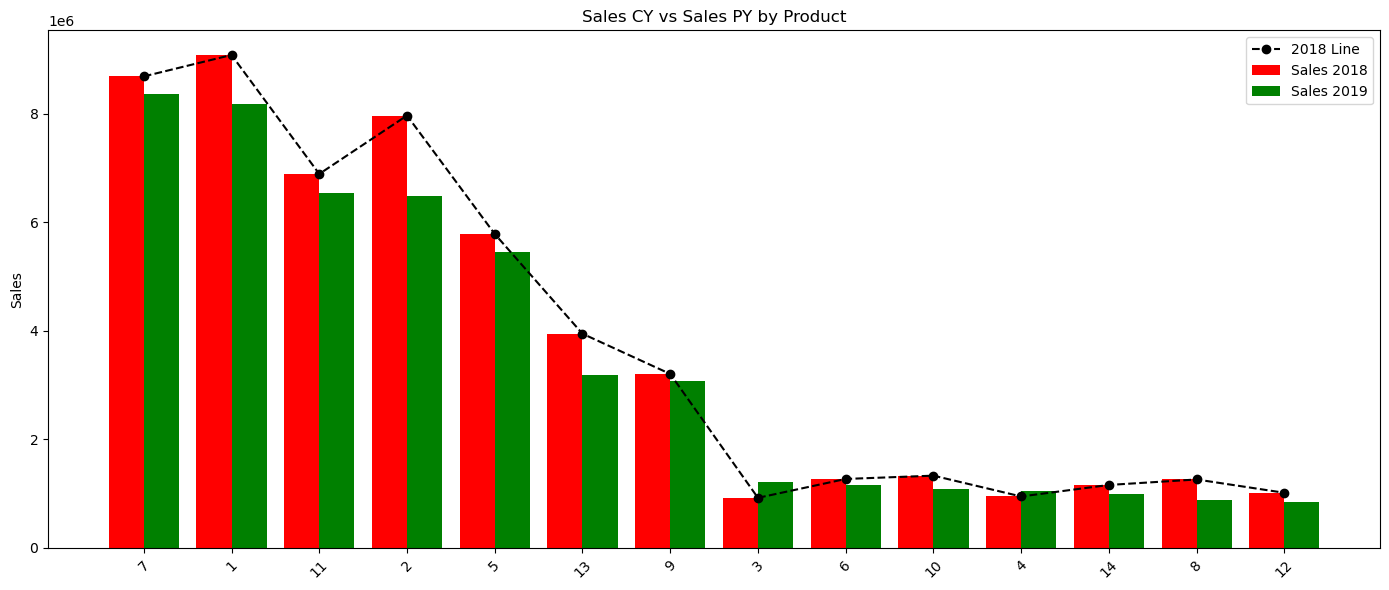

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Product and Year
sales_product_year = sales_df_copy.groupby(['Product', 'Year'])['Sales'].sum().reset_index()

# Pivot to get one column for each year's sales
pivot_df = sales_product_year.pivot(index='Product', columns='Year', values='Sales').fillna(0)

# Sort products by current year sales (last column)
pivot_df = pivot_df.sort_values(by=pivot_df.columns[-1], ascending=False)

# Extract current and previous year (last and second-last column)
current_year = pivot_df.columns[-1]
prev_year = pivot_df.columns[-2] if len(pivot_df.columns) >= 2 else None

# Plot setup
plt.figure(figsize=(14, 6))

bar_width = 0.4
x = range(len(pivot_df))

# Bar: Previous Year (Red)
plt.bar([i - bar_width/2 for i in x], pivot_df[prev_year], width=bar_width, label=f'Sales {prev_year}', color='red')

# Bar: Current Year (Green)
plt.bar([i + bar_width/2 for i in x], pivot_df[current_year], width=bar_width, label=f'Sales {current_year}', color='green')

# Dotted Line: Previous Year
plt.plot(x, pivot_df[prev_year], color='black', linestyle='--', marker='o', label=f'{prev_year} Line')

# Labels and formatting
plt.xticks(x, pivot_df.index, rotation=45)
plt.ylabel('Sales')
plt.title('Sales CY vs Sales PY by Product')
plt.legend()
plt.tight_layout()
plt.show()


<h2>Ventes par mois et comparaison avec l’année précédente</h2>

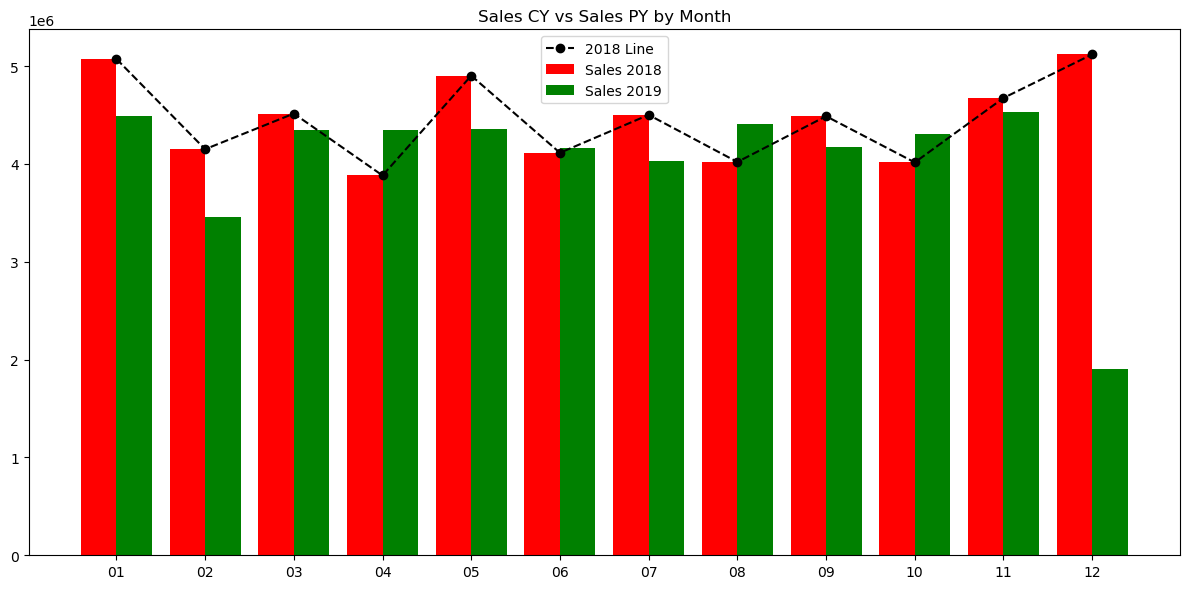

In [28]:
# Group sales by Month and Year
sales_month_year = sales_df_copy.groupby(['Month', 'Year'])['Sales'].sum().reset_index()
pivot_month = sales_month_year.pivot(index='Month', columns='Year', values='Sales').fillna(0)
pivot_month = pivot_month.sort_index()

# Extract years
current_year = pivot_month.columns[-1]
prev_year = pivot_month.columns[-2]

# Plot
plt.figure(figsize=(12, 6))
x = range(1, 13)
plt.bar([i - bar_width/2 for i in x], pivot_month[prev_year], width=bar_width, color='red', label=f'Sales {prev_year}')
plt.bar([i + bar_width/2 for i in x], pivot_month[current_year], width=bar_width, color='green', label=f'Sales {current_year}')
plt.plot(x, pivot_month[prev_year], color='black', linestyle='--', marker='o', label=f'{prev_year} Line')

plt.xticks(x, [f'{i:02d}' for i in x])
plt.title('Sales CY vs Sales PY by Month')
plt.legend()
plt.tight_layout()
plt.show()


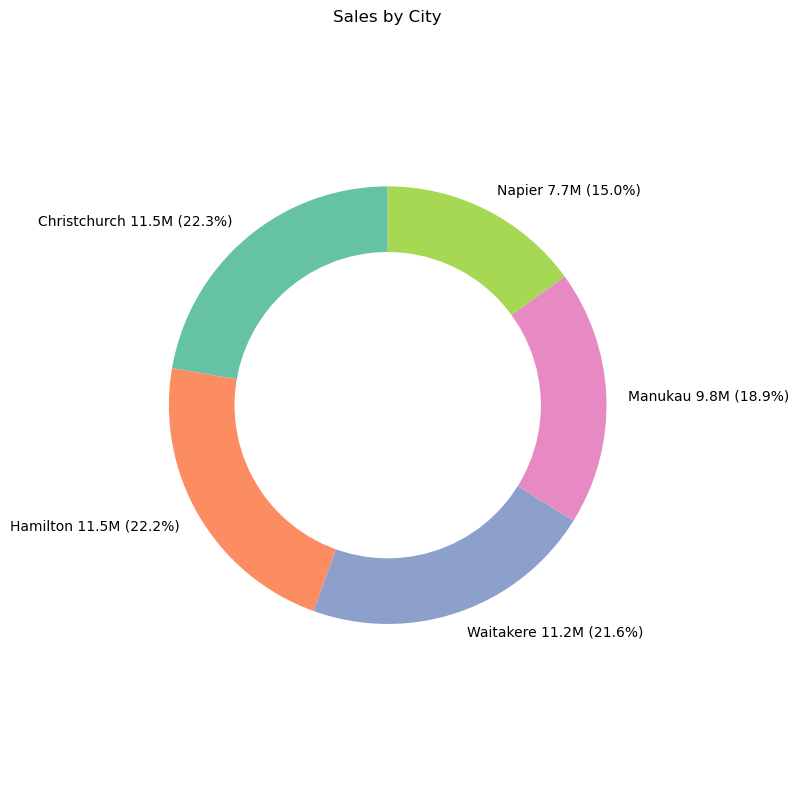

In [29]:
# Sales by city
city_sales = sales_df_copy.groupby('City')['Sales'].sum().sort_values(ascending=False)
top_cities = city_sales.head(5)

# Donut Chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette("Set2", len(top_cities))
wedges, texts, autotexts = plt.pie(
    top_cities,
    labels=[f"{city} {sales/1e6:.1f}M ({(sales/top_cities.sum()*100):.1f}%)" for city, sales in top_cities.items()],
    autopct='',
    startangle=90,
    colors=colors,
    textprops=dict(color="black")
)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)
plt.title("Sales by City")
plt.axis('equal')
plt.tight_layout()
plt.show()


/tmp/ipykernel_4714/1080839523.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  margin_data = sales_df_copy.groupby('Channel').apply(lambda x: x['Profit'].sum() / x['Sales'].sum()).reset_index(name='Profit Margin')


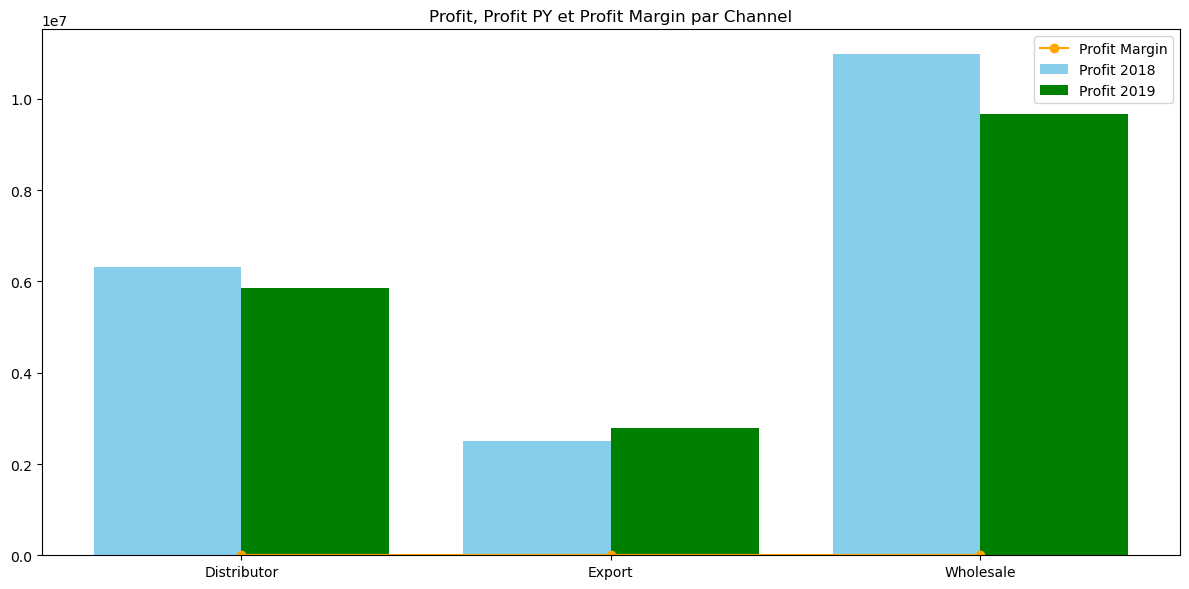

In [30]:
# Profit and margin by channel
profit_data = sales_df_copy.groupby(['Channel', 'Year'])[['Profit']].sum().reset_index()
margin_data = sales_df_copy.groupby('Channel').apply(lambda x: x['Profit'].sum() / x['Sales'].sum()).reset_index(name='Profit Margin')

# Plot bar for profit (current + previous)
pivot_profit = profit_data.pivot(index='Channel', columns='Year', values='Profit').fillna(0)
current_year = pivot_profit.columns[-1]
prev_year = pivot_profit.columns[-2]

plt.figure(figsize=(12, 6))
x = range(len(pivot_profit))
plt.bar([i - bar_width/2 for i in x], pivot_profit[prev_year], width=bar_width, label=f'Profit {prev_year}', color='skyblue')
plt.bar([i + bar_width/2 for i in x], pivot_profit[current_year], width=bar_width, label=f'Profit {current_year}', color='green')

# Profit margin as line
plt.plot(x, margin_data['Profit Margin'] * 100, color='orange', marker='o', label='Profit Margin')

plt.xticks(x, pivot_profit.index)
plt.title("Profit, Profit PY et Profit Margin par Channel")
plt.legend()
plt.tight_layout()
plt.show()


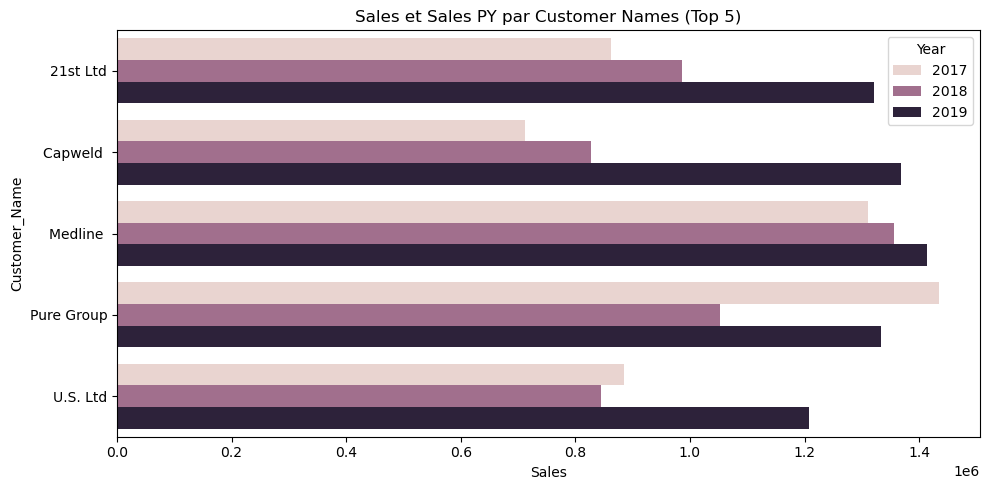

In [134]:
 #Top 5 customers
sales_df_copy = sales_df_copy.loc[:, ~sales_df_copy.columns.duplicated()]

client_sales = sales_df_copy.groupby(['Customer_Name', 'Year'])['Sales'].sum().reset_index()
top_customers = (
    client_sales[client_sales['Year'] == current_year]
    .nlargest(5, 'Sales')
    .Customer_Name
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=client_sales[client_sales['Customer_Name'].isin(top_customers)],
    x='Sales', y='Customer_Name', hue='Year', orient='h'
)
plt.title("Sales et Sales PY par Customer Names (Top 5)")
plt.tight_layout()
plt.show()

In [130]:
print(sales_df_copy.dtypes)


OrderNumber                   object
Date                  datetime64[ns]
Ship Date             datetime64[ns]
Customer                      object
Channel                       object
Currency Code                 object
Warehouse Code                object
Region                         int64
Product                        int64
Order_Quantity                 int64
Unit_Selling_Price           float64
Unit_cost                    float64
Sales                        float64
Cost                         float64
Profit                       float64
Customer_Name                 object
City                          object
Year                           int32
Month                          int32
Month_Name                    object
dtype: object


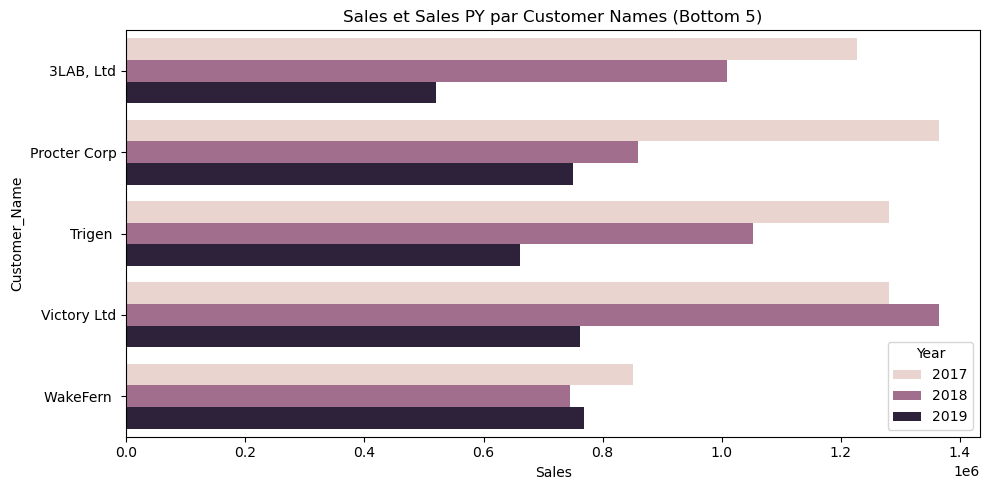

In [132]:
# Bottom 5 customers
last_customers = (
    client_sales[client_sales['Year'] == current_year]
    .nsmallest(5, 'Sales')
    .Customer_Name
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=client_sales[client_sales['Customer_Name'].isin(last_customers)],
    x='Sales', y='Customer_Name', hue='Year', orient='h'
)
plt.title("Sales et Sales PY par Customer Names (Bottom 5)")
plt.tight_layout()
plt.show()
